In [19]:
import numpy as np


import matplotlib.pyplot as plt
from scipy.misc import imresize
from scipy.optimize import linear_sum_assignment
%matplotlib inline
from time import time
   
from PIL import Image
import numpy as np
print('hola')

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
data_train = input_data.read_data_sets('/tmp/', one_hot=True).train 
data_test = input_data.read_data_sets('/tmp/', one_hot=True).test 


hola
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


In [67]:
from scipy.special import logsumexp
def sinkhorn(log_alpha, n_iters=20):

    for n in range(n_iters):
        log_alpha -= logsumexp(log_alpha, axis=1, keepdims=True)
        log_alpha -= logsumexp(log_alpha, axis=0, keepdims=True)
        if n%10000==1:
            print(n)
    log_alpha -= logsumexp(log_alpha, axis=1, keepdims=True)
    return np.exp(log_alpha)

def batch_split(batch, n_squares_side, n_channels=1):
    if(n_channels ==1):
        #side = int(np.sqrt(batch.shape[1]))
        side =batch.shape[1]
    else:
        side = batch.shape[1]
    batch_size = batch.shape[0]
    n_squares = n_squares_side ** 2
    
    batch = np.reshape(batch, [-1, side, side, n_channels])
    batch = np.reshape(batch, [batch_size, n_squares_side, side/n_squares_side, side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    batch = np.reshape(batch, [batch_size, side/n_squares_side, n_squares, side/n_squares_side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    return batch

def stack_batch_split(batch):
    return np.reshape(batch, [batch.shape[0]*batch.shape[1], batch.shape[2], batch.shape[3], batch.shape[4]])


def unflatten_batch(batch, n_channels=1):
    side_square = int(np.sqrt(batch.shape[2]/n_channels))
    return np.reshape(batch, [batch.shape[0], batch.shape[1], side_square, side_square, n_channels])

def join_batch_split(batch):
    batch_size = batch.shape[0]
    n_squares = batch.shape[1]
    side_quare = batch.shape[2]
    n_channels = batch.shape[4]
    n_squares_side = int(np.sqrt(n_squares))
    batch = np.transpose(batch, [0, 1, 3, 2, 4])
    batch = np.reshape(batch, [batch_size, n_squares_side, side_square*n_squares_side, side_square, n_channels])
    batch = np.transpose(batch, [0,1, 3,2,4])
    batch = np.reshape(batch, [batch_size, 1, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    batch = np.reshape(batch, [batch_size, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    return batch

def resized_dims(n_squares_side):
    if(n_squares_side==2):
        side = 28
        side_square = 14
    if(n_squares_side==3):
        side = 27
        side_square = 9
    if(n_squares_side==4):
        side = 28
        side_square = 7
    if(n_squares_side==5):
        side = 30
        side_square = 6
    if(n_squares_side==6):
        side = 30
        side_square = 5
    if(n_squares_side==7):
        side = 28
        side_square = 4
    if(n_squares_side==8):
        side = 32
        side_square = 4
    if(n_squares_side==9):
        side = 27
        side_square = 3
    if(n_squares_side==16):
        side = 80
        side_square = 5
    if(n_squares_side==14):
        side = 196
        side_square = 14
    if(n_squares_side==18):
        side = 8*18
        side_square = 8
    if(n_squares_side==20):
        side = 7*20
        side_square = 7
    if(n_squares_side==25):
        side = 25*6
        side_square = 6
    if(n_squares_side==30):
        side = 30*5
        side_square = 5
    if (n_squares_side == 37):
        side = 37 * 4
        side_square = 4
    if (n_squares_side == 45):
        side = 45 * 3
        side_square = 3
    return side, side_square

def resize_batch_color(batch, side_new, n_channels):
    batch_new = np.zeros((batch.shape[0], side_new, side_new, n_channels))
    side = int(np.sqrt(batch.shape[1]))
    for i in range(batch.shape[0]):
        for c in range(n_channels):
            a = imresize(batch[i,:,:,c], [side_new, side_new])
            
            a = a/255.0
            batch_new[i,:,:,c] =a
    return batch_new


def soft_to_hard(soft_perm):
    
    a,b = linear_sum_assignment(-soft_perm)
    ma = np.zeros((np.shape(soft_perm)))
    for i in range(soft_perm.shape[0]):
        ma[i, b[i]] = 1
    return ma


def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data


In [169]:
def similarities(stacked_batch, batch_size):
    
    log_alpha = np.reshape(stacked_batch, [batch_size, n_squares, n_dim])
    sq = np.sum(log_alpha **2, axis=2, keepdims=True)
    A = np.tile(sq, [1, 1, n_squares])
    B = np.tile(np.transpose(sq, [0,2 ,1]), [1, n_squares, 1])
    C = -2*np.matmul(log_alpha, np.transpose(log_alpha, [0, 2, 1]))
    s1 = A+B +C
    return s1

In [54]:
#Now we define the main TF variables
from copy import deepcopy
def solve(scrambled_split,stack_scrambled_images_split,stack_real_images_split):
    
    
    log_alpha = np.reshape(stack_scrambled_images_split, [batch_size, n_squares, n_dim])
    log_alpha2 = np.reshape(stack_real_images_split, [batch_size, n_squares, n_dim])



    sq = np.sum(log_alpha **2, axis=2, keepdims=True)
    A = np.tile(sq, [1, 1, n_squares])
    B = np.tile(np.transpose(sq, [0,2 ,1]), [1, n_squares, 1])
    C = -2*np.matmul(log_alpha, np.transpose(log_alpha, [0, 2, 1]))
    s1 = A+B +C
    sq2 = np.sum(log_alpha2 **2, axis=2, keepdims=True)
    A2 = np.tile(sq2, [1, 1, n_squares])
    B2 = np.tile(np.transpose(sq2, [0,2 ,1]), [1, n_squares, 1])
    C2 = np.matmul(-2*log_alpha2, np.transpose(log_alpha2, [0, 2, 1]))
    s2 = A2+B2 +C2
    f1 = np.tile(np.sum(s1**2, axis=2, keepdims=True),[1, 1, n_squares]) 
    f2 = np.transpose(np.tile(np.sum(s2**2, axis=2, keepdims=True),[1, 1, n_squares]), [0, 2 ,1]) 
    
    P = np.tile(np.eye(n_squares)[np.newaxis,:,:], [batch_size, 1, 1])
    
    invP_all = []
    ma_all = []
        
    for l in range(n_gromov):
        invP_all.append(deepcopy(np.transpose(P, [0, 2,1])))
     
        ma = -1*(f1+f2 - 2*np.matmul(s1, np.matmul(P, s2)))
        ma_all.append(ma)
        
        
        for k in range(batch_size):
            #print([l,k, s1.shape])
            #P[k,:,:] = sinkhorn(ma[k,:,:]/temp, n_iters = n_iter_sinkhorn)
            a=time()
            if(l<=100):
                P[k,:,:] = sinkhorn(ma[k,:,:]/temp, n_iters = n_iter_sinkhorn)
                print([np.percentile(np.sum(P[k,:,:], axis=0), 5), np.percentile(np.sum(P[k,:,:], axis=0),95)])
            else:
                P[k,:,:] = soft_to_hard(ma[k,:,:])
            print(time()-a)
    invP_all.append(deepcopy(np.transpose(P, [0, 2,1])))
        
    
    inv_P = np.transpose(P, [0, 2,1])
   
    scrambled_split_tiled = np.reshape(scrambled_split, [batch_size, n_squares, side_square ** 2* n_channels])

    ordered_inf = np.matmul(inv_P, scrambled_split_tiled)

    return ordered_inf,inv_P, invP_all,ma_all

(5, 28, 28, 1)
1
[0.9500000000000005, 1.009259259259262]
0.0613348484039
0.00190901756287
(1, 80, 80, 1)
0.0743169784546
(1, 80, 80, 1)


/home/gomena/.local/lib/python2.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


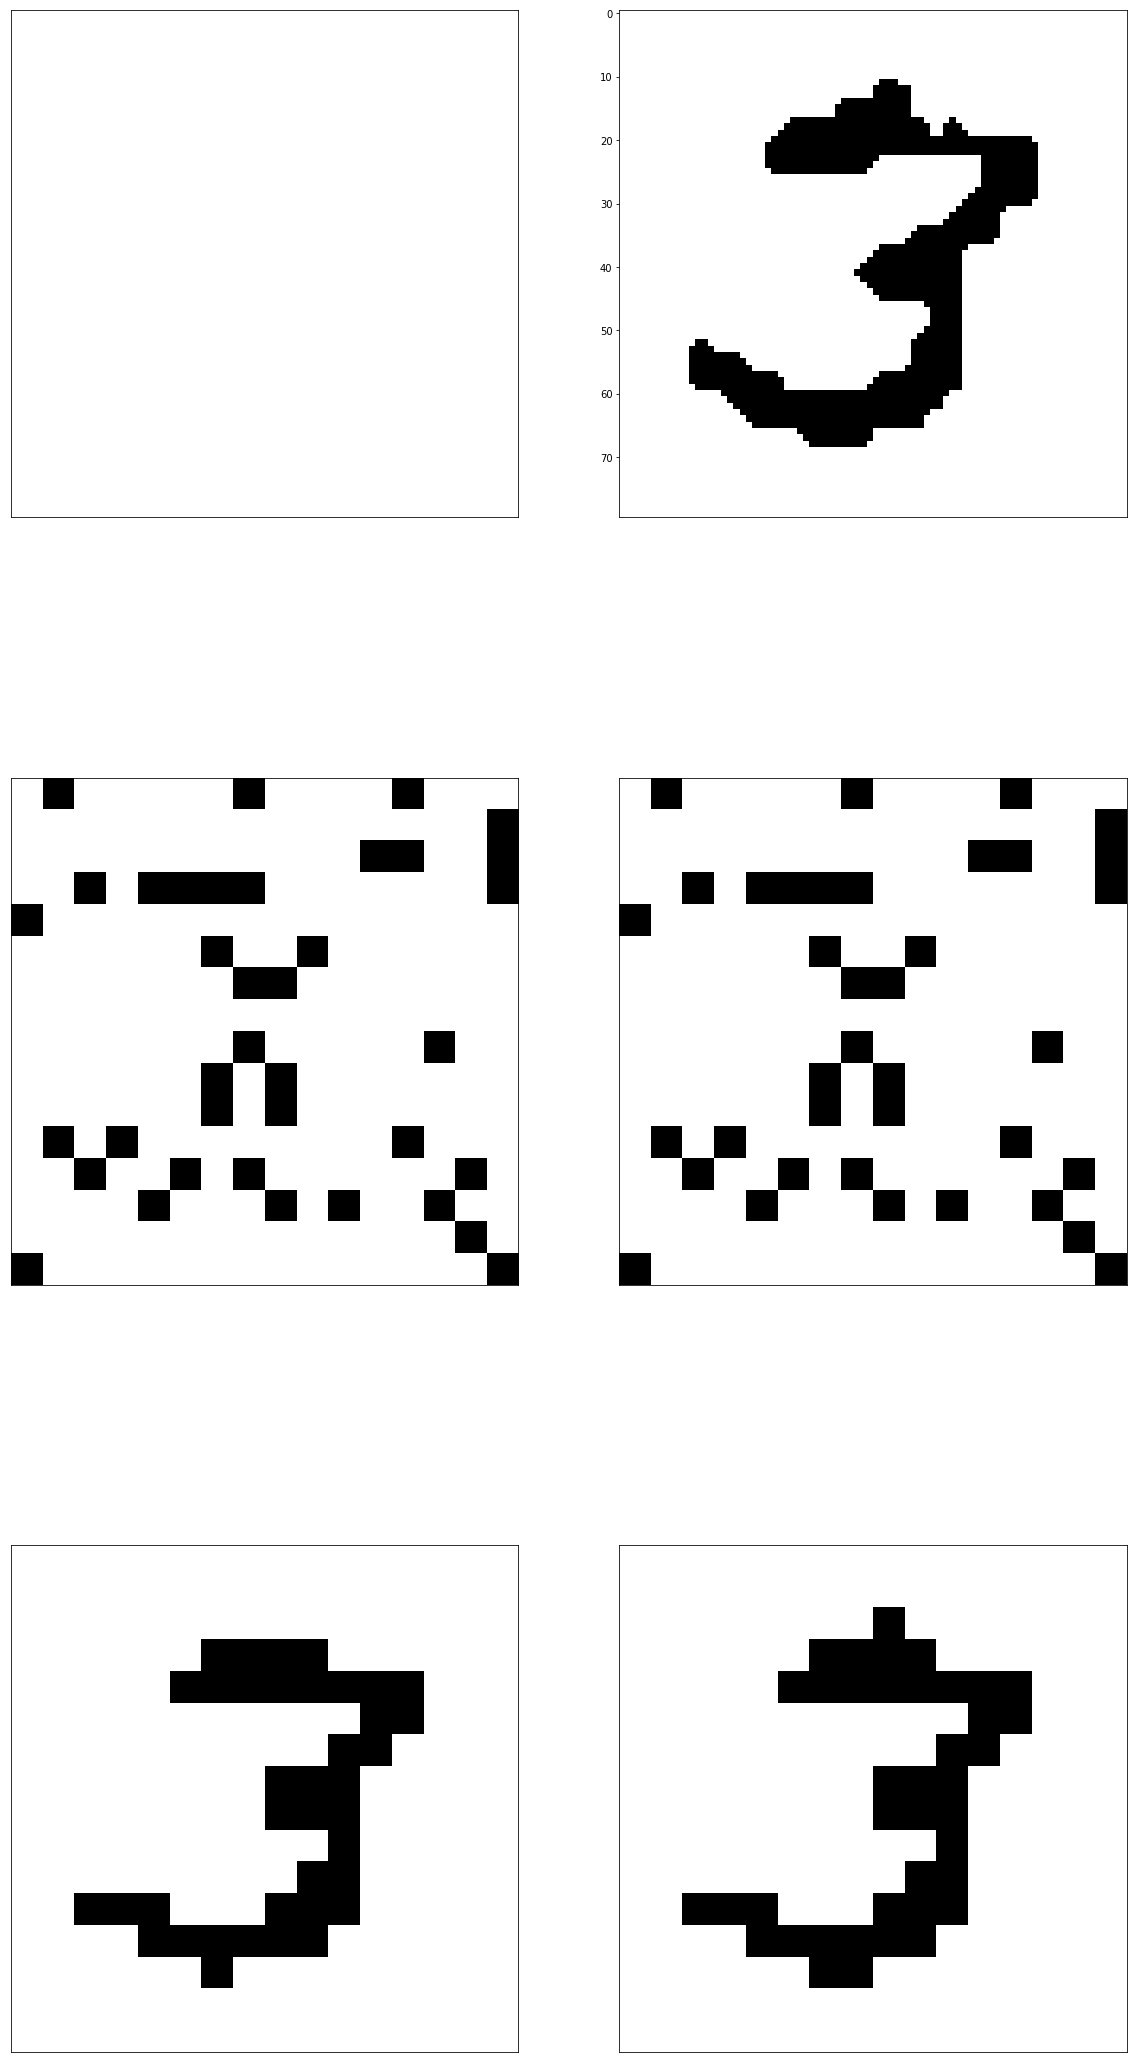

In [429]:
#Define model params
batch_size = 1
batch_size_display = batch_size
n_iter_sinkhorn = 50

temp = 2

#mnist data
n_squares_side = 16
n_channels = 1

n_squares = n_squares_side **2
n_gromov = 1
side, side_square = resized_dims(n_squares_side)
n_dim = int(side_square*side_square*n_channels)

np.random.seed(1)
ims,np_y=data_train.next_batch(5)
ims = np.expand_dims(np.reshape(ims, [-1, 28,28]),axis=3)
ims[ims>0.5]=1
ims[ims<0.5]=0
fig, ax = plt.subplots(n_gromov+2,2,figsize=(20,40))
inv_perms =[]
inv_soft_perms =[]
sip=[]

print(ims.shape)
np_x1 = resize_batch_color(np.expand_dims(ims[0,:,:, :], axis=0), side, n_channels)
np_x2 = resize_batch_color(np.expand_dims(ims[-1,:,:, :], axis=0), side, n_channels)
np_x1[np_x1>0.5]=0
np_x1[np_x1<0.5]=0
np_x2[np_x2>0.5]=1
np_x2[np_x2<0.5]=0
nx2 = np.nansum(np_x2) 
prop = nx2/(side**2)*np.random.uniform(0.8,1.2)
real_images_split = batch_split(np_x1, n_squares_side, n_channels)
for j in range(int(n_squares*prop)):
    real_images_split[:,j,:,:] = 0*round(np.mean(real_images_split[:,j,:,:,:]))+1
    
real_images_split2 = batch_split(np_x2, n_squares_side, n_channels)

scrambled_images_split = np.zeros(real_images_split.shape)




perm = np.arange(n_squares)
np.random.seed(1)
perm = np.random.permutation(n_squares)
i=0
scrambled_images_split[i,:, :, :] = real_images_split[i, perm, :, :]
stacked_scrambled_images_split = stack_batch_split(scrambled_images_split)
stacked_real_images_split = stack_batch_split(real_images_split2)


unscrambled_images, inv_soft_perms_np,invP_all,ma_all=solve(scrambled_images_split,
                                                            stacked_scrambled_images_split,
                                                            stacked_real_images_split)

unscrambled_images = unscrambled_images[:batch_size_display,:,:]
unflatten_inf = unflatten_batch(unscrambled_images, n_channels)


joined_inf = join_batch_split(unflatten_inf)
joined_scrambled = join_batch_split(scrambled_images_split)
joined_real = join_batch_split(real_images_split2)

#Compare reconstructions with real data




a=time()
ax[0,0].imshow(np_x1[i,:,:,0],cmap='Greys')
ax[0,0].get_xaxis().set_visible(False)
ax[0,0].get_yaxis().set_visible(False)
ax[0,1].imshow(np_x2[i,:,:,0],cmap='Greys')
ax[0,1].get_xaxis().set_visible(False)
ax[1,1].get_yaxis().set_visible(False)

for l in range(n_gromov+1):
    inv_hard_perms= np.zeros((batch_size_display, n_squares, n_squares))
    inv_soft_perms= np.zeros((batch_size_display, n_squares, n_squares))
    a=time()
    if(l<=-1):
        inv_hard_perms[i,:,:] = deepcopy(invP_all[l][i,:,:])
        inv_soft_perms[i,:,:] = deepcopy(invP_all[l][i,:,:]) 
    else:
        inv_hard_perms[i,:,:] = deepcopy(soft_to_hard(invP_all[l][i,:,:]))
        inv_soft_perms[i,:,:] = deepcopy(invP_all[l][i,:,:] )
           
    inv_perms.append(inv_hard_perms)
    print(time()-a)



    hard_inf = np.matmul(inv_hard_perms, np.reshape(scrambled_images_split[:batch_size_display,:,:,:], [batch_size_display,n_squares_side **2 ,-1]))
    soft_inf = np.matmul(inv_soft_perms, np.reshape(scrambled_images_split[:batch_size_display,:,:,:], [batch_size_display,n_squares_side **2 ,-1]))
    
    unflatten_hard_inf =np.reshape(hard_inf, unflatten_inf.shape)
    joined_hard_inf =join_batch_split(unflatten_hard_inf)
    unflatten_soft_inf =np.reshape(soft_inf, unflatten_inf.shape)
    joined_soft_inf =join_batch_split(unflatten_soft_inf)

    print(joined_hard_inf.shape)
    ax[l+1,0].imshow(joined_hard_inf[i,:,:,0],cmap='Greys')
    ax[l+1,0].get_xaxis().set_visible(False)
    ax[l+1,0].get_yaxis().set_visible(False)
    ax[l+1,1].imshow(joined_soft_inf[i,:,:,0],cmap='Greys')
    ax[l+1,1].get_xaxis().set_visible(False)
    ax[l+1,1].get_yaxis().set_visible(False)


In [377]:
batch_size =100
ims_test,np_y=data_test.next_batch(batch_size)
ims_test[ims_test<0.5] = 0
ims_test[ims_test>0.5] = 1
ims_test = np.expand_dims(np.reshape(ims_test, [-1, 28,28]),axis=3)

ims_test = resize_batch_color(ims_test, side, n_channels)
ims_test_split = batch_split(ims_test, n_squares_side, n_channels)
ims_test_stacked = stack_batch_split(ims_test_split)
print(stacked_real_images_split.shape)

sim = similarities(ims_test_stacked, batch_size)

/home/gomena/.local/lib/python2.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


(62500, 6, 6, 1)


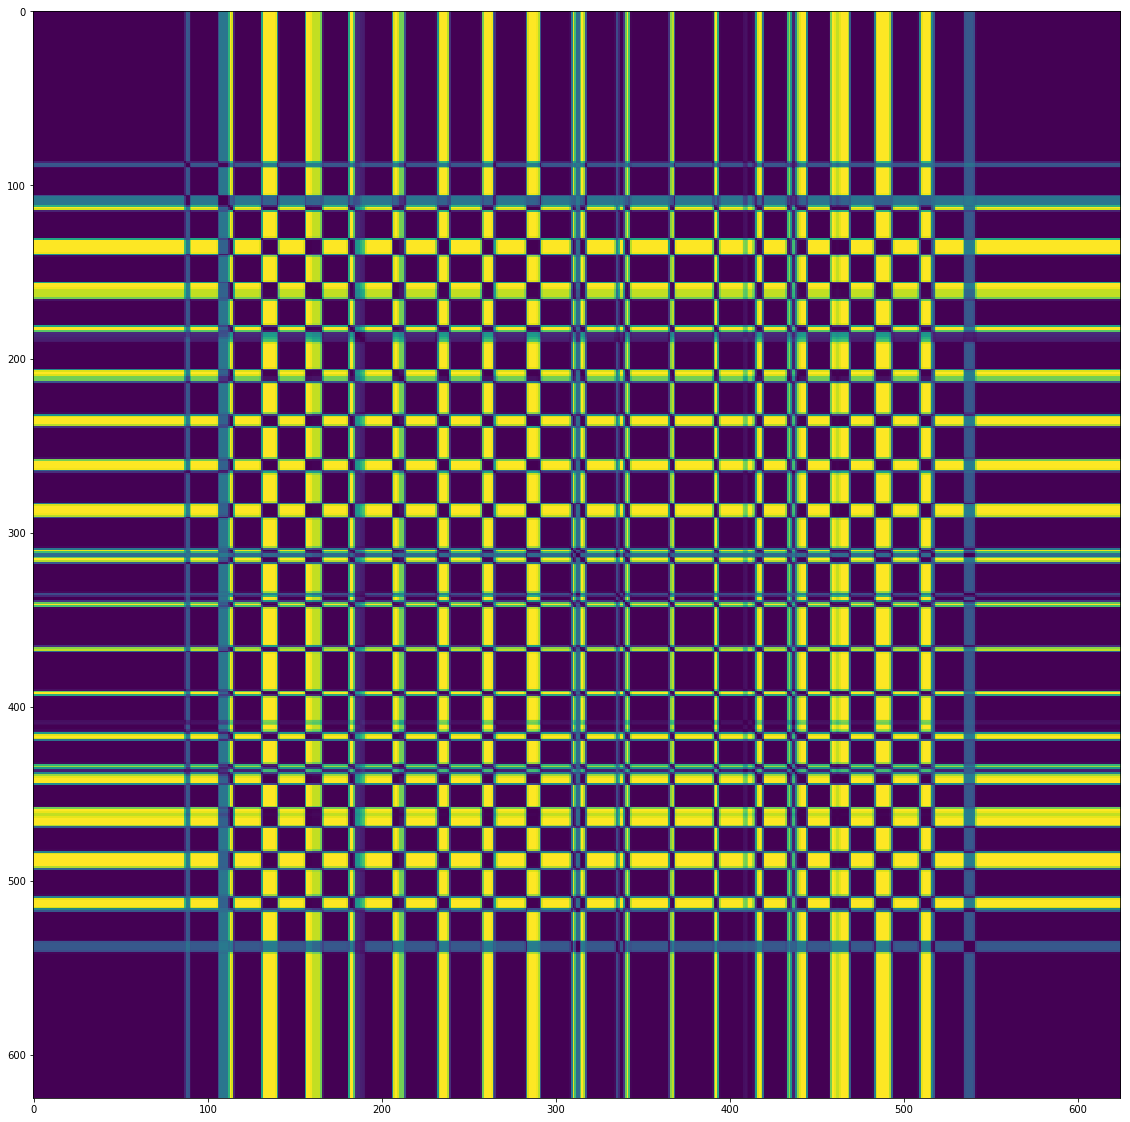

In [360]:
plt.figure(figsize=(20,20))
plt.imshow(np.mean(sim[0:,:,:], axis=0))


In [361]:
ma1 = np.expand_dims(np.tile(np.array(range(150))/6, [150,1]), axis=0)
ma1 = np.expand_dims(ma1, axis=3)

ma2 = np.transpose(ma1, [0,2,1,3])

ma1_split = batch_split(ma1, n_squares_side, n_channels)
ma1_stacked = stack_batch_split(ma1_split)
ma2_split = batch_split(ma2, n_squares_side, n_channels)
ma2_stacked = stack_batch_split(ma2_split)

ma_sim1 = np.sqrt(similarities(ma1_stacked, 1))
ma_sim2 = np.sqrt(similarities(ma2_stacked, 1))
ma_total = (ma_sim1 + ma_sim2) /6

In [312]:
print(ma_total.shape)

(1, 625, 625)


In [123]:
print(real_images_split.shape)

(1, 256, 5, 5, 1)


In [273]:
print(sim.shape)

(100, 150, 150, 1)


In [269]:

distsort=ma_total.flatten()

<Figure size 1440x1440 with 0 Axes>

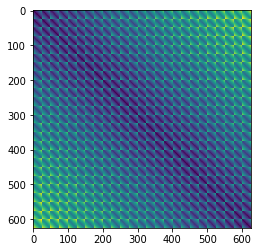

In [362]:
plt.imshow(ma_total[0,:,:])

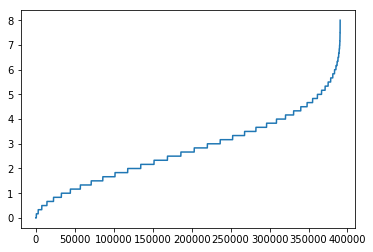

In [363]:
plt.plot(np.sort(ma_total.flatten())/6)

In [401]:
a = ma_total.flatten()
c=np.argsort(a)
b = np.reshape(sim,[batch_size, -1])

[u,v,w] = np.linalg.svd(b)

MemoryError: 

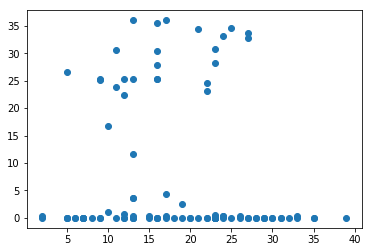

In [399]:
s = np.random.choice(len(a), 100)
#plt.scatter(a,b)
plt.scatter(a[c[s]],b[1,c[s]])

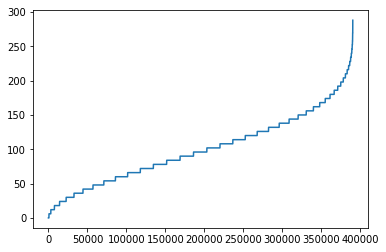

In [326]:
plt.plot(np.sort(a))

In [304]:
ma1_split[0,2,:,:]

array([[[12],
        [13],
        [14],
        [15],
        [16],
        [17]],

       [[12],
        [13],
        [14],
        [15],
        [16],
        [17]],

       [[12],
        [13],
        [14],
        [15],
        [16],
        [17]],

       [[12],
        [13],
        [14],
        [15],
        [16],
        [17]],

       [[12],
        [13],
        [14],
        [15],
        [16],
        [17]],

       [[12],
        [13],
        [14],
        [15],
        [16],
        [17]]])

In [305]:
print(ma1.shape)

(1, 150, 150, 1)


array([ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
        2,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 11, 11,
       11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14,
       14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19,
       19, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22,
       22, 22, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24])

In [358]:
print(ma_total[0,0,:])

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.
 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25.  2.  3.  4.  5.
  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23.
 24. 25. 26.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27.  4.  5.  6.  7.  8.  9. 10. 11.
 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.  5.
  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.  7.  8.  9. 10. 11.
 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 31. 32.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30

In [405]:
ims_test_split.shape

(100, 625, 6, 6, 1)